In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# The Symptoms of COVID-19

In [2]:
#get information from WHO website
symptoms={'symptom':['Fever',
        'Dry cough',
        'Fatigue',
        'Sputum production',
        'Shortness of breath',
        'Muscle pain',
        'Sore throat',
        'Headache',
        'Chills',
        'Nausea or vomiting',
        'Nasal congestion',
        'Diarrhoea',
        'Haemoptysis',
        'Conjunctival congestion'],'percentage':[87.9,67.7,38.1,33.4,18.6,14.8,13.9,13.6,11.4,5.0,4.8,3.7,0.9,0.8]}

symptoms=pd.DataFrame(data=symptoms,index=range(14))
symptoms

symptom  percentage
0                     Fever        87.9
1                 Dry cough        67.7
2                   Fatigue        38.1
3         Sputum production        33.4
4       Shortness of breath        18.6
5               Muscle pain        14.8
6               Sore throat        13.9
7                  Headache        13.6
8                    Chills        11.4
9        Nausea or vomiting         5.0
10         Nasal congestion         4.8
11                Diarrhoea         3.7
12              Haemoptysis         0.9
13  Conjunctival congestion         0.8

In [3]:
#Bar chart for symptoms of covid-19
fig = px.bar(symptoms[['symptom', 'percentage']].sort_values('percentage', ascending=False), 
             y="percentage", x="symptom", color='symptom', 
             log_y=True, template='ggplot2', title='Symptoms of COVID-19')
fig.show()
plt.savefig('(bar)Symptoms of COVID-19.png')

<Figure size 432x288 with 0 Axes>

In [4]:
#pie chart about symptoms
fig = px.pie(symptoms,
             values="percentage",
             names="symptom",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="percent+label")
fig.show()
plt.savefig('(percent)Symptoms of COVID-19.png')

<Figure size 432x288 with 0 Axes>

# Loading Datasets

In [5]:
#Loading data from git repository which will keep the data update
df0 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
date_usa = datetime.strptime(df0.columns[-1],'%m/%d/%y').strftime("%m-%d-%Y")
df_temp = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date_usa+".csv")
df1 = df_temp.loc[df_temp["Country_Region"]== "US"]
df1 = df1.rename(columns={"Admin2":"County"})
df2 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [6]:
df0

Province/State         Country/Region        Lat       Long  1/22/20  \
0              NaN            Afghanistan  33.939110  67.709953        0   
1              NaN                Albania  41.153300  20.168300        0   
2              NaN                Algeria  28.033900   1.659600        0   
3              NaN                Andorra  42.506300   1.521800        0   
4              NaN                 Angola -11.202700  17.873900        0   
..             ...                    ...        ...        ...      ...   
261            NaN  Sao Tome and Principe   0.186400   6.613100        0   
262            NaN                  Yemen  15.552727  48.516388        0   
263            NaN                Comoros -11.645500  43.333300        0   
264            NaN             Tajikistan  38.861000  71.276100        0   
265            NaN                Lesotho -29.610000  28.233600        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  7/13/20  7/14/20  \
0          0        0        0        0        0  ...    34455    34740   
1          0        0        0        0        0  ...     3571     3667   
2          0        0        0        0        0  ...    19689    20216   
3          0        0        0        0        0  ...      858      861   
4          0        0        0        0        0  ...      525      541   
..       ...      ...      ...      ...      ...  ...      ...      ...   
261        0        0        0        0        0  ...      732      732   
262        0        0        0        0        0  ...     1498     1516   
263        0        0        0        0        0  ...      317      321   
264        0        0        0        0        0  ...     6596     6643   
265        0        0        0        0        0  ...      245      256   

     7/15/20  7/16/20  7/17/20  7/18/20  7/19/20  7/20/20  7/21/20  7/22/20  
0      34994    35070    35229    35301    35475    35526    35615    35727  
1       3752     3851     3906     4008     4090     4171     4290     4358  
2      20770    21355    21948    22549    23084    23691    24278    24872  
3        862      877      880      880      880      884      884      889  
4        576      607      638      687      705      749      779      812  
..       ...      ...      ...      ...      ...      ...      ...      ...  
261      737      740      741      743      746      746      746      747  
262     1526     1552     1576     1581     1606     1619     1629     1640  
263      321      328      328      328      334      334      337      337  
264     6695     6741     6786     6834     6878     6921     6967     7015  
265      256      256      311      359      359      359      359      359  

[266 rows x 187 columns]

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 187 entries, Province/State to 7/22/20
dtypes: float64(2), int64(183), object(2)
memory usage: 388.7+ KB


In [8]:
df1

FIPS       County  Province_State Country_Region  \
0     45001.0    Abbeville  South Carolina             US   
1     22001.0       Acadia       Louisiana             US   
2     51001.0     Accomack        Virginia             US   
3     16001.0          Ada           Idaho             US   
4     19001.0        Adair            Iowa             US   
...       ...          ...             ...            ...   
3723     78.0          NaN  Virgin Islands             US   
3918  40129.0  Roger Mills        Oklahoma             US   
3921   2070.0   Dillingham          Alaska             US   
3923  16061.0        Lewis           Idaho             US   
3924  41069.0      Wheeler          Oregon             US   

              Last_Update        Lat       Long_  Confirmed  Deaths  \
0     2020-07-23 05:15:04  34.223334  -82.461707        249       2   
1     2020-07-23 05:15:04  30.295065  -92.414197       2011      59   
2     2020-07-23 05:15:04  37.767072  -75.632346       1057      15   
3     2020-07-23 05:15:04  43.452658 -116.241552       6423      40   
4     2020-07-23 05:15:04  41.330756  -94.471059         21       0   
...                   ...        ...         ...        ...     ...   
3723  2020-07-23 05:15:04  18.335800  -64.896300        320       7   
3918  2020-07-20 01:35:13  35.687117  -99.696662          3       0   
3921  2020-07-17 18:35:12  59.796037 -158.238194          1       0   
3923  2020-07-10 02:34:22  46.233153 -116.434146          1       0   
3924  2020-07-06 19:33:59  44.726982 -120.028143          0       0   

      Recovered  Active                   Combined_Key  Incidence_Rate  \
0             0   247.0  Abbeville, South Carolina, US     1015.207730   
1             0  1952.0          Acadia, Louisiana, US     3241.195906   
2             0  1042.0         Accomack, Virginia, US     3270.825597   
3             0  6383.0                 Ada, Idaho, US     1333.715403   
4             0    21.0                Adair, Iowa, US      293.624161   
...         ...     ...                            ...             ...   
3723          0   313.0             Virgin Islands, US      298.318231   
3918          0     3.0      Roger Mills, Oklahoma, US       83.728719   
3921          0     1.0         Dillingham, Alaska, US       20.341741   
3923          0     1.0               Lewis, Idaho, US       26.055237   
3924          0     0.0            Wheeler, Oregon, US        0.000000   

      Case-Fatality_Ratio  
0                0.803213  
1                2.933864  
2                1.419111  
3                0.622762  
4                0.000000  
...                   ...  
3723             2.187500  
3918             0.000000  
3921             0.000000  
3923             0.000000  
3924                  NaN  

[3241 rows x 14 columns]

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3924
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3230 non-null   float64
 1   County               3235 non-null   object 
 2   Province_State       3241 non-null   object 
 3   Country_Region       3241 non-null   object 
 4   Last_Update          3241 non-null   object 
 5   Lat                  3177 non-null   float64
 6   Long_                3177 non-null   float64
 7   Confirmed            3241 non-null   int64  
 8   Deaths               3241 non-null   int64  
 9   Recovered            3241 non-null   int64  
 10  Active               3240 non-null   float64
 11  Combined_Key         3241 non-null   object 
 12  Incidence_Rate       3177 non-null   float64
 13  Case-Fatality_Ratio  3196 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 379.8+ KB


In [10]:
df1.describe()

FIPS          Lat        Long_      Confirmed        Deaths  \
count   3230.000000  3177.000000  3177.000000    3241.000000   3241.000000   
mean   32355.307121    37.879989   -91.262064    1224.956803     44.180808   
std    17938.194800     6.091246    14.435449    6595.837872    452.622660   
min       66.000000    13.444300  -174.159600       0.000000      0.000000   
25%    19047.500000    34.291452   -97.729251      38.000000      0.000000   
50%    30058.000000    38.116241   -89.797459     141.000000      2.000000   
75%    47038.500000    41.684477   -82.927528     535.000000     12.000000   
max    99999.000000    69.314792   145.673900  222444.000000  23428.000000   

          Recovered        Active  Incidence_Rate  Case-Fatality_Ratio  
count  3.241000e+03  3.240000e+03     3177.000000          3196.000000  
mean   3.736035e+02  8.189284e+02      800.333014             2.241473  
std    2.126917e+04  2.155978e+04      913.255457             3.422010  
min    0.000000e+00 -1.173568e+06        0.000000             0.000000  
25%    0.000000e+00  3.700000e+01      245.394962             0.000000  
50%    0.000000e+00  1.370000e+02      504.246713             1.155526  
75%    0.000000e+00  5.217500e+02     1044.787024             3.118360  
max    1.210849e+06  1.990160e+05    13718.539525            68.806073

In [11]:
df2

Province/State         Country/Region        Lat       Long  1/22/20  \
0              NaN            Afghanistan  33.939110  67.709953        0   
1              NaN                Albania  41.153300  20.168300        0   
2              NaN                Algeria  28.033900   1.659600        0   
3              NaN                Andorra  42.506300   1.521800        0   
4              NaN                 Angola -11.202700  17.873900        0   
..             ...                    ...        ...        ...      ...   
261            NaN  Sao Tome and Principe   0.186400   6.613100        0   
262            NaN                  Yemen  15.552727  48.516388        0   
263            NaN                Comoros -11.645500  43.333300        0   
264            NaN             Tajikistan  38.861000  71.276100        0   
265            NaN                Lesotho -29.610000  28.233600        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  7/13/20  7/14/20  \
0          0        0        0        0        0  ...     1012     1048   
1          0        0        0        0        0  ...       95       97   
2          0        0        0        0        0  ...     1018     1028   
3          0        0        0        0        0  ...       52       52   
4          0        0        0        0        0  ...       26       26   
..       ...      ...      ...      ...      ...  ...      ...      ...   
261        0        0        0        0        0  ...       14       14   
262        0        0        0        0        0  ...      424      429   
263        0        0        0        0        0  ...        7        7   
264        0        0        0        0        0  ...       55       56   
265        0        0        0        0        0  ...        3        3   

     7/15/20  7/16/20  7/17/20  7/18/20  7/19/20  7/20/20  7/21/20  7/22/20  
0       1094     1113     1147     1164     1181     1185     1186     1190  
1        101      104      107      111      112      113      117      120  
2       1040     1052     1057     1068     1078     1087     1100     1111  
3         52       52       52       52       52       52       52       52  
4         27       28       29       29       29       29       30       33  
..       ...      ...      ...      ...      ...      ...      ...      ...  
261       14       14       14       14       14       14       14       14  
262      433      438      440      443      445      447      456      458  
263        7        7        7        7        7        7        7        7  
264       56       56       56       57       57       57       57       58  
265        3        3        6        6        6        6        6        6  

[266 rows x 187 columns]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 187 entries, Province/State to 7/22/20
dtypes: float64(2), int64(183), object(2)
memory usage: 388.7+ KB


In [13]:
missing_values_count0 = df0.isnull().sum()
print(missing_values_count0)

Province/State    185
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
7/18/20             0
7/19/20             0
7/20/20             0
7/21/20             0
7/22/20             0
Length: 187, dtype: int64


In [14]:
missing_values_count1 = df1.isnull().sum()
print(missing_values_count1)

FIPS                   11
County                  6
Province_State          0
Country_Region          0
Last_Update             0
Lat                    64
Long_                  64
Confirmed               0
Deaths                  0
Recovered               0
Active                  1
Combined_Key            0
Incidence_Rate         64
Case-Fatality_Ratio    45
dtype: int64


In [15]:
missing_values_count2 = df2.isnull().sum()
print(missing_values_count2)

Province/State    185
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
7/18/20             0
7/19/20             0
7/20/20             0
7/21/20             0
7/22/20             0
Length: 187, dtype: int64


In [16]:
#deal with the missing data
#df1 = df1.replace(np.nan, '', regex = True)

In [17]:
# use three-sigma method to detect outliers 
def outlier(x,k):
    # x is a column of a dataframe, k is how many times of standard deviations, usually k=3
    loc   = []
    temp  = []
    mean  = np.mean(x)
    std   = np.std(x)
    lower = mean-k*std
    upper = mean+k*std
    for id in x.index:
        if x[id]<lower or x[id]>upper:
            loc.append(id)
            temp.append(x[id])          
           
    return pd.Series(temp,loc)
    # return the index of rows, and the outlier value

In [18]:
print("Number of outliers for columns:\n" ,
      "FIPS:",outlier(df1['FIPS'],3).count(),"\n",
      "Lat:",outlier(df1['Lat'],3).count(),"\n",
      "Long_:",outlier(df1['Long_'],3).count(),"\n", 
      "Confirmed:",outlier(df1['Confirmed'],3).count(),"\n",
      "Deaths:",outlier(df1['Deaths'],3).count(),"\n",
     "Recovered:",outlier(df1['Recovered'],3).count(),"\n",
     "Active:",outlier(df1['Active'],3).count(),"\n",
     "Incidence_Rate:",outlier(df1['Incidence_Rate'],3).count(),"\n",
     "Case-Fatality_Ratio:",outlier(df1['Case-Fatality_Ratio'],3).count())

Number of outliers for columns:
 FIPS: 51 
 Lat: 103 
 Long_: 26 
 Confirmed: 24 
 Deaths: 14 
 Recovered: 1 
 Active: 6 
 Incidence_Rate: 55 
 Case-Fatality_Ratio: 47


In [19]:
#get total confirmed cases and death cases
total = df1.sum()
total.name = "Total"
pd.DataFrame(total).transpose().loc[:,["Confirmed","Deaths"]].style.background_gradient(cmap='Purples',axis=1)

In [20]:
#Creat chart plot to show more details about confirmed cases and deaths cases in USA
df_t0= df0.groupby(["Country/Region"]).sum()
df_t1= np.asarray(df_t0[df_t0.index == "US"].iloc[:,2:])[0]
df_t2= df2.groupby(["Country/Region"]).sum()
df_t3= np.asarray(df_t2[df_t2.index == "US"].iloc[:,2:])[0]
df_t3
fig,ax=plt.subplots(2,1,figsize = (10,10))

ax[0].plot(df_t1, 'r.-')
ax[0].set_ylabel('Confirmed Cases in USA')
ax[1].plot(df_t3, 'b.-')
ax[1].set_ylabel('Death Cases in USA')
ax[1].set_xlabel('Date from 01-22-2020 Until to 07-22-2020')

fig.suptitle('Confirmed Cases and Deaths Cases in USA')

plt.show()

In [21]:
#here is the table about 10 most affected states by COVID-19 in USA
df1.loc[:,["Province_State","Confirmed","Deaths","County"]].sort_values("Confirmed",ascending=False).set_index("County")[:10].style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])

In [22]:
#Create bar chart for Top 10 states of confirmed cases in USA
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df1.groupby(["Province_State"]).sum().sort_values('Confirmed')["Confirmed"].index[-10:],df1.groupby(["Province_State"]).sum().sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States of Confirmed Cases in USA",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States of Confirmed Cases in USA.png')

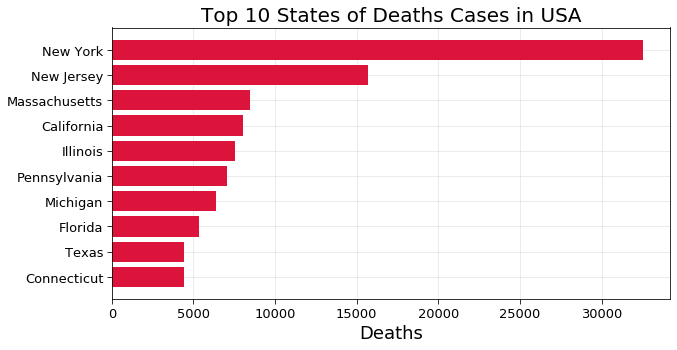

In [23]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df1.groupby(["Province_State"]).sum().sort_values('Deaths')["Deaths"].index[-10:],df1.groupby(["Province_State"]).sum().sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States of Deaths Cases in USA",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States of Deaths Cases.png')

In [24]:
# url = "https://raw.githubusercontent.com/Subhash9325/GeoJson-Data-of-Indian-States/master/Indian_States"
# state_json = requests.get(url).json()
df1 = df1.replace(np.nan, 0, regex=True)
usa = folium.Map(location=[37, -102], zoom_start=4,max_zoom=9,min_zoom=4)
for i in np.int32(np.asarray(df1[df1['Confirmed'] > 0].index)):
    folium.Circle(
        location=[df1.loc[i]['Lat'], df1.loc[i]['Long_']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df1.loc[i]['Province_State']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df1.loc[i]['County']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df1.loc[i]['Confirmed'])+"</li>"+
        "<li>Active:   "+str(df1.loc[i]['Active'])+"</li>"+
        "<li>Recovered:   "+str(df1.loc[i]['Recovered'])+"</li>"+       
        "<li>Deaths:   "+str(df1.loc[i]['Deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df1.loc[i]['Deaths']/(df1.loc[i]['Confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=int((np.log2(df1.loc[i]['Confirmed']+1))*6000),
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(usa)

usa

In [25]:
state_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json').json()
county_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us_counties_20m_topo.json').json()
# county_geo

In [26]:
data_temp = df1.groupby(["Province_State"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_temp["Confirmed_log"] = np.log10(data_temp["Confirmed"]+1)
bins = list(data_temp['Confirmed_log'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=6,min_zoom=3)
 
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data = data_temp,
    columns=['Province_State', 'Confirmed_log'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = bins,
    reset=True,
    legend_name='Confirmed cases 10^x'
).add_to(m)
folium.LayerControl().add_to(m)

legend_html = "<div style='padding:10px;background-color:rgba(255,255,255,0.5);position:fixed;bottom:20px;left:20px;z-index:1000'>"
legend_html += "<div style='width:100%;text-align:center;'><h4>Units from lite red to deep red </h4></div><hr style='border-top-color: rgba(25,25,25,0.5);'>"
legend_html += "<ul style='margin:0;padding:0;color: #555;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"
for i in bins:
    legend_html += "<li style='margin:0;padding:0;line-height: 0;'>Value "+str(np.round(i,2))+" : "+str(int(10**i)-1)+"</li><br>"
legend_html += "</ul></div>"
m.get_root().html.add_child(folium.Element(legend_html))
m

In [27]:
#use np.corrcoef to plot correlation coefficients between variables
#green means has a high correlation, lite green means has a low correlation.
df1.iloc[:,:].corr().style.background_gradient(cmap='Greens').format("{:.3f}")

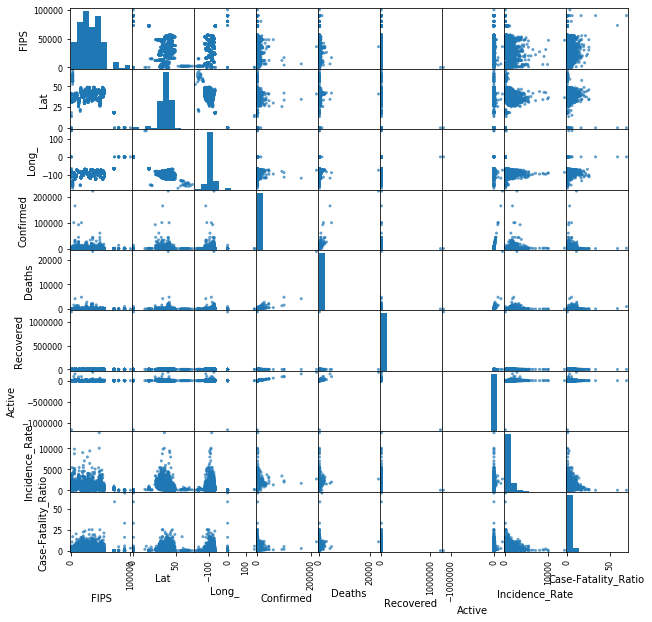

In [28]:
pd.plotting.scatter_matrix(df1, alpha=0.7, figsize=(10,10), diagonal='hist')
plt.show()

In [29]:
df0 = df0.rename(columns={"Province/State":"state","Country/Region": "country"})
df0.loc[df0['country'] == "US", "country"] = "USA"
def total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    

In [30]:
#Visible = Input(shape=(1,))
#Dense_l1 = Dense(80,name="Dense_l1")(Visible)
#LRelu_l1 = LeakyReLU(name = "LRelu_l1")(Dense_l1)
#Dense_l2 = Dense(80,name = "Dense_l2")(LRelu_l1)
#LRelu_l2 = LeakyReLU(name = "LRelu_l2")(Dense_l2)
#Dense_l3 = Dense(1,name="Dense_l3")(LRelu_l2)
#LRelu_l3 = LeakyReLU(name = "Output")(Dense_l3)
#usa_model1 = models.Model(inputs=Visible, outputs=LRelu_l3)
## Compile model
#usa_model1.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error',metrics=['accuracy'])
#usa_model1.summary()
##save the model to local computer
# usa_model1.save('usa_model1')

In [31]:
from sklearn.cross_validation import train_test_split
df3 = df0.groupby(["country"]).sum()
df3 = np.asarray(df3[df3.index == "USA"].iloc[:,2:])[0]
data_y = np.log10(df3).astype("float32")
data_x = np.arange(1,len(data_y)+1)
X = data_x.reshape([data_x.shape[0],1]) 
y = data_y.reshape([data_y.shape[0],1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#data_y
#data_x.shape[0]

In [32]:
usa_model1 = models.load_model("usa_model1.h5")
usa_model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0   

In [33]:
usa_model1.fit(X_train,y_train,epochs=1000,batch_size=64)

Epoch 1/1000
183/183 [==============================] - 0s 747us/step - loss: 0.0022 - accuracy: 0.0109
Epoch 2/1000
183/183 [==============================] - 0s 26us/step - loss: 0.0020 - accuracy: 0.0109
Epoch 3/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 4/1000
183/183 [==============================] - 0s 26us/step - loss: 0.0023 - accuracy: 0.0109
Epoch 5/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0022 - accuracy: 0.0109
Epoch 6/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 7/1000
183/183 [==============================] - 0s 37us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 8/1000
183/183 [==============================] - 0s 30us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 9/1000
183/183 [==============================] - 0s 33us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 10/1000
183/183 [==============================] - 0s 35us/step - 

183/183 [==============================] - 0s 32us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 158/1000
183/183 [==============================] - 0s 28us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 159/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0029 - accuracy: 0.0109
Epoch 160/1000
183/183 [==============================] - 0s 31us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 161/1000
183/183 [==============================] - 0s 46us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 162/1000
183/183 [==============================] - 0s 30us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 163/1000
183/183 [==============================] - 0s 35us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 164/1000
183/183 [==============================] - 0s 34us/step - loss: 0.0021 - accuracy: 0.0109
Epoch 165/1000
183/183 [==============================] - 0s 36us/step - loss: 0.0049 - accuracy: 0.0109
Epoch 166/1000
183/183 [==============================] - 0s 33us/step

183/183 [==============================] - 0s 30us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 314/1000
183/183 [==============================] - 0s 35us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 315/1000
183/183 [==============================] - 0s 26us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 316/1000
183/183 [==============================] - 0s 43us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 317/1000
183/183 [==============================] - 0s 31us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 318/1000
183/183 [==============================] - 0s 39us/step - loss: 0.0029 - accuracy: 0.0109
Epoch 319/1000
183/183 [==============================] - 0s 35us/step - loss: 0.0034 - accuracy: 0.0109
Epoch 320/1000
183/183 [==============================] - 0s 38us/step - loss: 0.0030 - accuracy: 0.0109
Epoch 321/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0034 - accuracy: 0.0109
Epoch 322/1000
183/183 [==============================] - 0s 34us/step

183/183 [==============================] - 0s 40us/step - loss: 0.0037 - accuracy: 0.0109
Epoch 470/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0052 - accuracy: 0.0109
Epoch 471/1000
183/183 [==============================] - 0s 35us/step - loss: 0.0032 - accuracy: 0.0109
Epoch 472/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0022 - accuracy: 0.0109
Epoch 473/1000
183/183 [==============================] - 0s 29us/step - loss: 0.0028 - accuracy: 0.0109
Epoch 474/1000
183/183 [==============================] - 0s 29us/step - loss: 0.0037 - accuracy: 0.0109
Epoch 475/1000
183/183 [==============================] - 0s 34us/step - loss: 0.0036 - accuracy: 0.0109
Epoch 476/1000
183/183 [==============================] - 0s 51us/step - loss: 0.0053 - accuracy: 0.0109
Epoch 477/1000
183/183 [==============================] - 0s 49us/step - loss: 0.0090 - accuracy: 0.0109
Epoch 478/1000
183/183 [==============================] - 0s 31us/step

183/183 [==============================] - 0s 29us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 626/1000
183/183 [==============================] - 0s 33us/step - loss: 0.0019 - accuracy: 0.0109
Epoch 627/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0020 - accuracy: 0.0109
Epoch 628/1000
183/183 [==============================] - 0s 29us/step - loss: 0.0016 - accuracy: 0.0109
Epoch 629/1000
183/183 [==============================] - 0s 41us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 630/1000
183/183 [==============================] - 0s 29us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 631/1000
183/183 [==============================] - 0s 30us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 632/1000
183/183 [==============================] - 0s 33us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 633/1000
183/183 [==============================] - 0s 34us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 634/1000
183/183 [==============================] - 0s 30us/step

183/183 [==============================] - 0s 34us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 782/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0020 - accuracy: 0.0109
Epoch 783/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 784/1000
183/183 [==============================] - 0s 27us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 785/1000
183/183 [==============================] - 0s 37us/step - loss: 0.0016 - accuracy: 0.0109
Epoch 786/1000
183/183 [==============================] - 0s 30us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 787/1000
183/183 [==============================] - 0s 26us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 788/1000
183/183 [==============================] - 0s 33us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 789/1000
183/183 [==============================] - 0s 29us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 790/1000
183/183 [==============================] - 0s 37us/step

183/183 [==============================] - 0s 40us/step - loss: 0.0018 - accuracy: 0.0109
Epoch 938/1000
183/183 [==============================] - 0s 30us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 939/1000
183/183 [==============================] - 0s 41us/step - loss: 0.0025 - accuracy: 0.0109
Epoch 940/1000
183/183 [==============================] - 0s 51us/step - loss: 0.0017 - accuracy: 0.0109
Epoch 941/1000
183/183 [==============================] - 0s 33us/step - loss: 0.0016 - accuracy: 0.0109
Epoch 942/1000
183/183 [==============================] - 0s 36us/step - loss: 0.0016 - accuracy: 0.0109
Epoch 943/1000
183/183 [==============================] - 0s 35us/step - loss: 0.0020 - accuracy: 0.0109
Epoch 944/1000
183/183 [==============================] - 0s 39us/step - loss: 0.0026 - accuracy: 0.0109
Epoch 945/1000
183/183 [==============================] - 0s 40us/step - loss: 0.0029 - accuracy: 0.0109
Epoch 946/1000
183/183 [==============================] - 0s 28us/step

In [44]:
# evaluate the Logical Regression model build
_, accuracy = usa_model1.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

183/183 [==============================] - 0s 26us/step
Accuracy: 1.09


In [35]:
million = 1000000
prediction_days = 7
case_nums_country = df0.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]
df_temp = df0.groupby(["country"]).sum()
temp_data = np.asarray(df_temp[df_temp.index == "USA"].iloc[:,2:])[0]
data = np.power(10,usa_model1.predict(np.arange(1,len(temp_data)+prediction_days+1)))
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data,"-",color="blue", label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data,"-.",color="red",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0]/million)+" million\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Confirmed Cases for Next 7 Days Prediction Curve in USA",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases",fontsize =18)

plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig("Prediction Curve for Confirmed Cases in USA.png")
plt.show()

# LSTM/RNN

In [36]:
df4 = df0.groupby("country").sum().drop(['Lat','Long'],axis =1)
df5 = np.asarray(df4[df4.index == "USA"].iloc[:,2:])[0]
dataset= pd.DataFrame(df5)
dataset

0
0          2
1          2
2          5
3          5
4          5
..       ...
176  3711413
177  3773260
178  3834677
179  3899211
180  3970085

[181 rows x 1 columns]

In [37]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)]
test_data = dataset[:]
test_data
#train_data
#len(dataset)-7

0
0          2
1          2
2          5
3          5
4          5
..       ...
176  3711413
177  3773260
178  3834677
179  3899211
180  3970085

[181 rows x 1 columns]

In [38]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'] )
lstm_model.fit(generator, epochs = 1000)

Epoch 1/1000
176/176 [==============================] - 3s 15ms/step - loss: 0.0183 - accuracy: 0.0057
Epoch 2/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0030 - accuracy: 0.0057
Epoch 3/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0042 - accuracy: 0.0057
Epoch 4/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0033 - accuracy: 0.0057
Epoch 5/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0038 - accuracy: 0.0057
Epoch 6/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0028 - accuracy: 0.0057
Epoch 7/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0048 - accuracy: 0.0057
Epoch 8/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0020 - accuracy: 0.0057
Epoch 9/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0041 - accuracy: 0.0057
Epoch 10/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.00

176/176 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.0057
Epoch 159/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0018 - accuracy: 0.0057
Epoch 160/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.0057
Epoch 161/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 162/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 163/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0010 - accuracy: 0.0057
Epoch 164/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0010 - accuracy: 0.0057
Epoch 165/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 166/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 167/1000
176/176 [==============================] - 1s 7ms/step - loss: 0

176/176 [==============================] - 1s 7ms/step - loss: 9.8193e-04 - accuracy: 0.0057
Epoch 237/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.9939e-04 - accuracy: 0.0057
Epoch 238/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0015 - accuracy: 0.0057
Epoch 239/1000
176/176 [==============================] - 1s 7ms/step - loss: 8.1937e-04 - accuracy: 0.0057
Epoch 240/1000
176/176 [==============================] - 1s 7ms/step - loss: 9.8356e-04 - accuracy: 0.0057
Epoch 241/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 242/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0012 - accuracy: 0.0057
Epoch 243/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.0057
Epoch 244/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 245/1000
176/176 [==============================] - 1s 7m

176/176 [==============================] - 1s 7ms/step - loss: 5.4679e-04 - accuracy: 0.0057
Epoch 390/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.8972e-04 - accuracy: 0.0057
Epoch 391/1000
176/176 [==============================] - 1s 7ms/step - loss: 8.4479e-04 - accuracy: 0.0057
Epoch 392/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.7835e-04 - accuracy: 0.0057
Epoch 393/1000
176/176 [==============================] - 1s 7ms/step - loss: 0.0012 - accuracy: 0.0057
Epoch 394/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.8176e-04 - accuracy: 0.0057
Epoch 395/1000
176/176 [==============================] - 1s 8ms/step - loss: 0.0011 - accuracy: 0.0057
Epoch 396/1000
176/176 [==============================] - 2s 9ms/step - loss: 7.9593e-04 - accuracy: 0.0057
Epoch 397/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.4455e-04 - accuracy: 0.0057
Epoch 398/1000
176/176 [===========================

176/176 [==============================] - 1s 7ms/step - loss: 6.3823e-04 - accuracy: 0.0057
Epoch 542/1000
176/176 [==============================] - 1s 7ms/step - loss: 5.8673e-04 - accuracy: 0.0057
Epoch 543/1000
176/176 [==============================] - 1s 7ms/step - loss: 9.1379e-04 - accuracy: 0.0057
Epoch 544/1000
176/176 [==============================] - 1s 7ms/step - loss: 8.2835e-04 - accuracy: 0.0057
Epoch 545/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.4545e-04 - accuracy: 0.0057
Epoch 546/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.9675e-04 - accuracy: 0.0057
Epoch 547/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.8623e-04 - accuracy: 0.0057
Epoch 548/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.3161e-04 - accuracy: 0.0057
Epoch 549/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.6630e-04 - accuracy: 0.0057
Epoch 550/1000
176/176 [===================

176/176 [==============================] - 1s 6ms/step - loss: 7.1917e-04 - accuracy: 0.0057
Epoch 618/1000
176/176 [==============================] - 1s 6ms/step - loss: 8.9868e-04 - accuracy: 0.0057
Epoch 619/1000
176/176 [==============================] - 1s 6ms/step - loss: 5.9288e-04 - accuracy: 0.0057
Epoch 620/1000
176/176 [==============================] - 1s 6ms/step - loss: 9.5875e-04 - accuracy: 0.0057
Epoch 621/1000
176/176 [==============================] - 1s 6ms/step - loss: 7.5208e-04 - accuracy: 0.0057
Epoch 622/1000
176/176 [==============================] - 1s 6ms/step - loss: 5.4576e-04 - accuracy: 0.0057
Epoch 623/1000
176/176 [==============================] - 1s 6ms/step - loss: 7.5610e-04 - accuracy: 0.0057
Epoch 624/1000
176/176 [==============================] - 1s 6ms/step - loss: 6.9220e-04 - accuracy: 0.0057
Epoch 625/1000
176/176 [==============================] - 1s 6ms/step - loss: 8.8166e-04 - accuracy: 0.0057
Epoch 626/1000
176/176 [===================

176/176 [==============================] - 1s 7ms/step - loss: 5.8663e-04 - accuracy: 0.0057
Epoch 694/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.9142e-04 - accuracy: 0.0057
Epoch 695/1000
176/176 [==============================] - 1s 7ms/step - loss: 5.2424e-04 - accuracy: 0.0057
Epoch 696/1000
176/176 [==============================] - 1s 8ms/step - loss: 5.0748e-04 - accuracy: 0.0057
Epoch 697/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.8366e-04 - accuracy: 0.0057
Epoch 698/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.5724e-04 - accuracy: 0.0057
Epoch 699/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.7849e-04 - accuracy: 0.0057
Epoch 700/1000
176/176 [==============================] - 1s 6ms/step - loss: 5.8495e-04 - accuracy: 0.0057
Epoch 701/1000
176/176 [==============================] - 1s 6ms/step - loss: 6.5247e-04 - accuracy: 0.0057
Epoch 702/1000
176/176 [===================

Epoch 845/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.4521e-04 - accuracy: 0.0057
Epoch 846/1000
176/176 [==============================] - 1s 7ms/step - loss: 5.1266e-04 - accuracy: 0.0057
Epoch 847/1000
176/176 [==============================] - 1s 7ms/step - loss: 5.7301e-04 - accuracy: 0.0057
Epoch 848/1000
176/176 [==============================] - 1s 8ms/step - loss: 6.1628e-04 - accuracy: 0.0057
Epoch 849/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.5877e-04 - accuracy: 0.0057
Epoch 850/1000
176/176 [==============================] - 1s 7ms/step - loss: 7.0247e-04 - accuracy: 0.0057
Epoch 851/1000
176/176 [==============================] - 1s 7ms/step - loss: 8.2792e-04 - accuracy: 0.0057
Epoch 852/1000
176/176 [==============================] - 1s 7ms/step - loss: 9.0048e-04 - accuracy: 0.0057
Epoch 853/1000
176/176 [==============================] - 1s 7ms/step - loss: 5.0976e-04 - accuracy: 0.0057
Epoch 854/1000
176/176 [====

176/176 [==============================] - 1s 6ms/step - loss: 7.2317e-04 - accuracy: 0.0057
Epoch 996/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.4234e-04 - accuracy: 0.0057
Epoch 997/1000
176/176 [==============================] - 1s 6ms/step - loss: 7.1809e-04 - accuracy: 0.0057
Epoch 998/1000
176/176 [==============================] - 1s 7ms/step - loss: 8.3606e-04 - accuracy: 0.0057
Epoch 999/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.0528e-04 - accuracy: 0.0057
Epoch 1000/1000
176/176 [==============================] - 1s 7ms/step - loss: 6.1123e-04 - accuracy: 0.0057


In [45]:
#overview the LSTM model
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

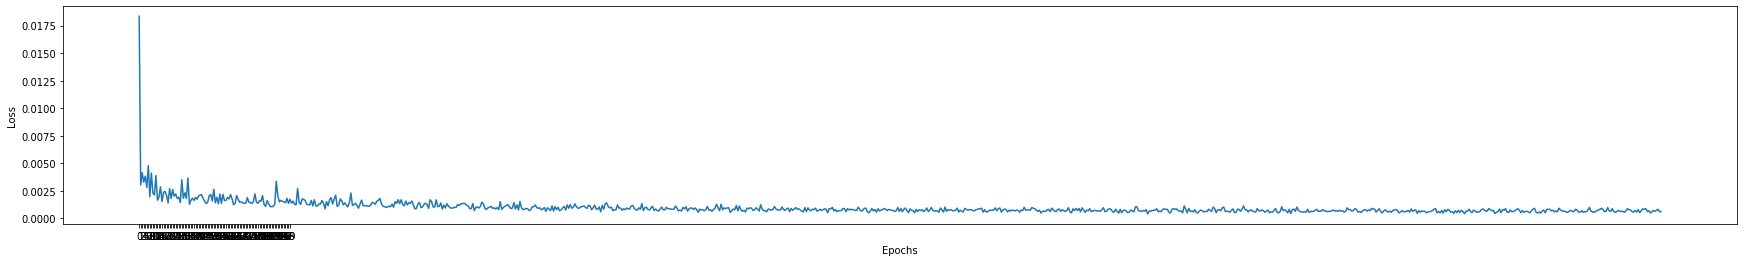

In [39]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [41]:
#output the predictions
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [42]:
#predictions of COVID-19 confirmed cases for next 7 days
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head(7)

0
0  3.996120e+06
1  4.024421e+06
2  4.049206e+06
3  4.066645e+06
4  4.078199e+06
5  4.085821e+06
6  4.092597e+06